# Assignment 7

## 2. Beta and expected returns

### a)

In [80]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
db = wrds.Connection()
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [jonkq]:jonkq
Enter your password:········


In [3]:
# get rf
rf=db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1980-01-01' and mcaldt<='2019-12-31'")
rf.to_csv('rf.csv')
# get value-weighted CRSP market return
vwret = db.raw_sql("select date, vwretd from crsp.msi where date>='1980-01-01' and date<='2019-12-31'")
vwret.to_csv('vwret.csv')

In [4]:
rf = pd.read_csv('rf.csv', usecols=['tmytm']).squeeze()
#Compute the monthly simple rate
rf_m = np.exp(rf/12/100)-1

vwret = pd.read_csv('vwret.csv', usecols=['vwretd']).squeeze()

In [5]:
stocks = db.raw_sql("""
                select a.permno, a.date, a.ret, b.exchcd, b.shrcd, a.shrout, a.prc 

                from crsp.msf as a left join crsp.msenames as b 
                
                on a.permno = b.permno and b.namedt <= a.date and a.date<=b.nameendt
                
                where a.date between '1980-01-01' and '2019-12-31'
                and b.exchcd between 1 and 2
                and b.shrcd between 10 and 11""",date_cols=['date'])

stocks.to_csv('stocks.csv')

### b)

In [8]:
stocks_df = pd.pivot_table(data=stocks, values='ret', index='date', columns='permno')

In [36]:
s = stocks_df.apply(sum)

In [37]:
s = list(s.isna())

In [43]:
s_i = []
for i in range(len(s)):
    if not s[i]:
        s_i.append(i)

In [46]:
stocks_df = stocks_df.iloc[:,s_i]

In [50]:
vwret_e = vwret - rf_m

In [53]:
stocks_e = stocks_df - rf_m

In [70]:
rf_m.index = stocks_df.index
stocks_e = stocks_df.subtract(rf_m, axis = 0)

In [106]:
N = stocks_e.shape[1]
betas = []
x = np.array(vwret_e).reshape((-1,1))

for i in range(N):
    y = np.array(stocks_e.iloc[:,i]).reshape((-1,1))
    lm = LinearRegression().fit(x,y)
    betas.append(lm.coef_.item())

In [110]:
betas_ord = list(np.argsort(betas))
betas_sort = list(np.sort(betas))

stocks_avg = np.array(stocks_df.apply(np.mean))

In [152]:
beta_pfs = [betas_sort[i*10:(i+1)*10] for i in range(10)]
beta_pfs[9].append(betas_sort[N-1])

In [128]:
stocks_avg_sort = stocks_avg[betas_ord]

In [139]:
stocks_avg_sort_pfs = [stocks_avg_sort[i*10:(i+1)*10] for i in range(10)]
stocks_avg_sort_pfs[9] = np.append(stocks_avg_sort_pfs[9], stocks_avg_sort[N-1])

In [153]:
stocks_avg_sort_pfs_m = []
beta_pfs_m = []
for i in range(10):
    stocks_avg_sort_pfs_m.append(np.mean(stocks_avg_sort_pfs[i]).item())
    beta_pfs_m.append(np.mean(beta_pfs[i]).item())

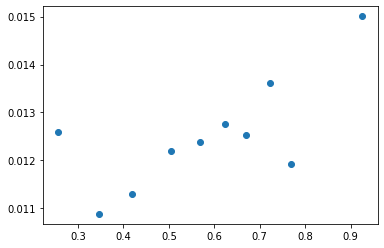

In [155]:
plt.scatter(beta_pfs_m, stocks_avg_sort_pfs_m)